In [1]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy as np

/home/ollie/pscholz/tripyview_github


In [2]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path ='/work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= 5
which_mode= 'transects'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_jayne_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'temp'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None # 'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
input_transect = list()
input_transect.append([[-30, -30],[-80, 90], 'Transect: -30°W, -80°S-90°N'])

#_____________________________________________________________________________________
do_clim   = True
which_clim= 'phc3'
clim_path = '/work/ollie/pscholz/INIT_HYDRO/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = None
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncolumn   = 3 
do_rescale= None
which_dpi = 300
which_res = 0.5
do_ylog   = True
do_contour= True

In [3]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True, do_eresol=[True,'mean'], do_nresol=[True,'eresol'])

#______________________________________________________________________________________________________
if which_cycl is not None: 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
    
    if ref_path is not None:
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)
        
#______________________________________________________________________________________________________        
cinfo=dict({'cstr':cstr, 'cnum':cnum}) 
if crange   is not None: cinfo['crange']=crange
if cmin     is not None: cinfo['cmin'  ]=cmin
if cmax     is not None: cinfo['cmax'  ]=cmax
if cref     is not None: cinfo['cref'  ]=cref
if cfac     is not None: cinfo['cfac'  ]=cfac  
if climit   is not None: cinfo['climit']=climit
if chist    is not None: cinfo['chist' ]=chist
if ctresh   is not None: cinfo['ctresh']=ctresh    
if ref_path is not None: cinfo['cref'  ]=0.0    

#______________________________________________________________________________________________________
# in case of diff plots
if ref_path is not None:
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
        
#______________________________________________________________________________________________________    
transects = tpv.analyse_transects(input_transect, which_res='res', res=which_res)

 > found *.pckl file: /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node.pckl
 > comp. e_resol from mean
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
0 /home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/5/


In [7]:
#___LOAD FESOM2 REFERENCE DATA________________________________________________________________________
if ref_path is not None:
    print(ref_path)
    if not vname=='Kv*N2':
        data_ref  = tpv.load_data_fesom2(mesh, ref_path, vname=vname, year=ref_year, mon=ref_mon, descript=ref_name, do_info=False, do_zarithm='None') 
    else:
        data_ref  = tpv.load_data_fesom2(mesh, ref_path, vname='Kv' , year=ref_year, mon=ref_mon, descript=ref_name , do_info=False, do_zarithm='None')
        data2_ref = tpv.load_data_fesom2(mesh, ref_path, vname='N2' , year=ref_year, mon=ref_mon, descript=ref_name , do_info=False, do_zarithm='None')
        data_ref['Kv'].data = data_ref['Kv'].data * data2_ref['N2'].data
        data_ref  = data.rename(dict({'Kv':'Kv*N2'}))
        data_ref['Kv*N2'].attrs['units'], data_ref['Kv*N2'].attrs['description'], data_ref['Kv*N2'].attrs['long_name'] = 'm^2/s^3', 'Kv * N^2', 'Kv * N^2'
        del(data2_ref)
    
    data_ref = tpv.load_transect_fesom2(mesh, data_ref, transects, do_compute=True)

#___LOAD FESOM2 DATA___________________________________________________________________________________
list_transects = list()
for datapath, descript in zip(input_paths, input_names):
    print(datapath, descript)
    if not vname=='Kv*N2':
        data  = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, descript=descript , do_info=False, do_zarithm='None')
    else:
        data  = tpv.load_data_fesom2(mesh, datapath, vname='Kv' , year=year, mon=mon, descript=descript , do_info=False, do_zarithm='None')
        data2 = tpv.load_data_fesom2(mesh, datapath, vname='N2' , year=year, mon=mon, descript=descript , do_info=False, do_zarithm='None')
        data['Kv'].data = data['Kv'].data * data2['N2'].data
        data  = data.rename(dict({'Kv':'Kv*N2'}))
        data['Kv*N2'].attrs['units'], data['Kv*N2'].attrs['description'], data['Kv*N2'].attrs['long_name'] = 'm^2/s^3', 'Kv * N^2', 'Kv * N^2'
        del(data2)
        
    data_transects  = tpv.load_transect_fesom2(mesh, data, transects, do_compute=True)
    
    #__________________________________________________________________________________________________    
    if ref_path is not None:
        list_transects.append(tpv.do_transectanomaly(data_transects, data_ref))  
    else:
        list_transects.append(data_transects)  
    del(data, data_transects)
    
if ref_path is not None: del(data_ref)    
    
#___APPEND ABS CLIMATOLOGY_____________________________________________________________________________    
if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname) and do_clim and  (ref_path is None): 
    clim_vname= vname
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim          = tpv.load_climatology(mesh, clim_path, clim_vname)
    clim_transect = tpv.load_transect_fesom2(mesh, clim, transects)    
    list_transects.append(clim_transect)

/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/5/ TKE


In [8]:
list_transects[0][0]

<xarray.Dataset>
Dimensions:  (nod2: 339, nz1: 47, lon: 339, lat: 339, dst: 339)
Coordinates:
  * nz1      (nz1) float64 2.5 7.5 15.0 25.0 ... 5.525e+03 5.825e+03 6.125e+03
    idz      (nz1) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45 46
  * lon      (lon) float64 -30.0 -30.0 -30.0 -30.0 ... -30.0 -30.0 -30.0 -30.0
  * lat      (lat) float64 -79.75 -79.25 -78.75 -78.25 ... 88.25 88.75 89.25
  * nod2     (nod2) int64 9008 9012 9012 9015 9513 ... 56218 56213 56215 56170
    w_A      (nod2) float64 9.195e+07 1.665e+08 ... 5.796e+08 7.039e+08
  * dst      (dst) float64 27.8 83.4 139.0 ... 1.871e+04 1.876e+04 1.882e+04
Data variables:
    temp     (nod2, nz1) float32 -1.648 -1.648 -1.648 -1.649 ... nan nan nan nan
Attributes: (12/19)
    FESOM_model:                         FESOM2
    FESOM_website:                       fesom.de
    FESOM_git_SHA:                       10fa79c
    FESOM_MeshPath:                      /work/ollie/pscholz/mesh_fesom2.0/co...
    FESOM_mesh_representative_checksum:  297ddf9c482ca68c86a979e1bd5d3c97
    FESOM_ClimateDataPath:               /work/ollie/projects/clidyn/FESOM2/h...
    ...                                  ...
    FESOM_include_fleapyear:             -1
    FESOM_use_floatice:                  0
    FESOM_whichEVP:                      0
    FESOM_evp_rheol_steps:               120
    FESOM_visc_option:                   5
    FESOM_w_split:                       0

--> histo: cmin, cmax =  -1.7877037525177002 27.188114166259766
--> histo: cmin, cmax =  -1.7877037525177002 27.188114166259766
{'cstr': 'blue2red', 'cnum': 20, 'chist': True, 'ctresh': 0.995, 'cmin': -1.79, 'cmax': 27.19, 'cref': 13.0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fbb80472750>, 'clevel': array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,
       11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.,
       24., 25., 26., 27., 28.])}


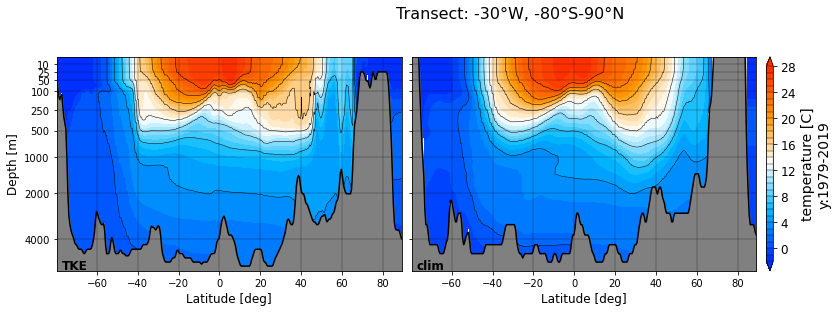

In [11]:
#________________________________________________________________________________________________________
# compute save path
spath  = save_path
sname  = list(list_transects[0][0].keys())[0]
slabel = list_transects[0][0][sname].attrs['str_lsave']
strans = list_transects[0][0][sname].attrs['transect_name'].replace(' ','_').lower()
if spath is not None: spath  = '{}/{}_{}_{}_{}.png'.format(spath, which_mode, sname, strans, slabel) 
ncolumn= np.min([ncolumn,len(list_transects)]) 
nrow   = np.ceil(len(list_transects)/ncolumn).astype('int')
if save_fname is not None: spath = save_fname
fig, ax, cbar = tpv.plot_transects(list_transects, transects, cinfo=cinfo, figsize=[ncolumn*7, nrow*3.5], n_rc=[nrow, ncolumn], 
                                pos_gap=[0.01, 0.01], pos_extend=[0.05, 0.05, 0.85,0.90], do_ylog=do_ylog, do_rescale=do_rescale, 
                                do_contour=do_contour, do_save = spath, save_dpi=which_dpi)